# Recommender_system_test 

В международном интернет-магазине с 2020-12-07 по 2021-01-04 (до 2020-12-21 шёл набор новых пользователей) был проведён А/B-тест. 

**Цель теста** - выяснить, повысятся ли пользовательские метрики из-за внедрения улучшенной рекомендательной системы.

### Техническое задание

- группы: А — контрольная, B — новая платёжная воронка;
- аудитория: 15% новых пользователей из региона EU;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

### Описание данных

**`ab_project_marketing_events.csv`** — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

**`final_ab_new_users.csv`** — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

**`final_ab_events.csv`** — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

**`final_ab_participants.csv`** — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Содержание

[Библиотеки](#library)

1. [Общая информация](#information)


2. [Предобработка данных](#preparation)
     - [Исследование соответсвия типов данных](#type);
     - [Объединение таблиц](#tables);
     - [Проверка данных на дубликаты](#dup). 
    
    
3. [Исследовательский анализ данных групп](#analytic)
    - [Проверка выборок на пересечение пользователей](#maping);
    - [Изучение событий (рассчёт частоты и распределение событий по дням)](#overview_events);
    - [Определение числа событий, приходящихся на одного пользователя](#events_users).
    
    
4. [Работа с продуктовой воронкой](#work_with_funnel)    
    - [Работа с пользователями, которые совершают события](#work_with_users);
    - [Порядк событий](#order_of_events);
    - [Анализ воронки (конверсия переходов)](#analytic_funnel). 
    
    
5. [Оценка результатов A/B-тестирования](#analytic_test)
    - [Результаты A/B-тестирования](#results)
    - [Статистический анализ (нахождение разницы долей z-критерием)](#statistic_analytic). 
    
[Общий вывод](#conclusion)

## Библиотеки <a id="library"></a>

In [1]:
#для работы с данными импортируем библиотеку pandas
import pandas as pd
#для работы с временем импортируем библиотеку datetime
import datetime as dt
#для построения графиков будем работать с matplotlib.pyplot
import matplotlib.pyplot as plt
#для построения более сложных и визуально красивее графиков добавим библиотеку seaborn
import seaborn as sns
#импортируем набор методов graph_objects для построения воронки
from plotly import graph_objects as go
#для работы с нормальным распределение и с z-тестом используем библиотеку stats 
from scipy import stats as st
#для применения математических операций(корень)
import math as mth

## 1. Общая информация <a id="information"></a>

In [2]:
#для прочтения файлов используем метод read_csv()
ab_project_marketing_events=pd.read_csv('/datasets/ab_project_marketing_events.csv')
#Для поверхностного анализа применяем метод info()
ab_project_marketing_events.info()
#Пропушенные значения ищем методом isna().sum()
print('Количество пропущенных значений:', ab_project_marketing_events.isna().sum(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes
Количество пропущенных значений:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


In [3]:
#просматриваем данные методом head()
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
#для прочтения файлов используем метод read_csv()
final_ab_new_users=pd.read_csv('/datasets/final_ab_new_users.csv')
#Для поверхностного анализа применяем метод info()
final_ab_new_users.info()
#Пропушенные значения ищем методом isna().sum()
print('Количество пропущенных значений:', final_ab_new_users.isna().sum(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB
Количество пропущенных значений:
user_id       0
first_date    0
region        0
device        0
dtype: int64


In [5]:
#просматриваем данные методом head()
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
#для прочтения файлов используем метод read_csv()
final_ab_events=pd.read_csv('/datasets/final_ab_events.csv')
#Для поверхностного анализа применяем метод info()
final_ab_events.info()
#Пропушенные значения ищем методом isna().sum()
print('Количество пропущенных значений:', final_ab_events.isna().sum(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
Количество пропущенных значений:
user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


In [7]:
#просматриваем данные методом head()
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
#для прочтения файлов используем метод read_csv()
final_ab_participants=pd.read_csv('/datasets/final_ab_participants.csv')
#Для поверхностного анализа применяем метод info()
final_ab_participants.info()
#Пропушенные значения ищем методом isna().sum()
print('Количество пропущенных значений:', final_ab_participants.isna().sum(), sep='\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB
Количество пропущенных значений:
user_id    0
group      0
ab_test    0
dtype: int64


In [9]:
#просматриваем данные методом head()
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


### Вывод

Все столбцы в таблицах, связанные с датами и врменем, имеют неверный тип данных, такие столбцы нужно привести к типу datetime[64ns]. Также в таблице final_ab_events в колонке details пропущенны комментарии в случае 377577/440317~86% данных, однако это всего лишь дополнительные данные о событии, которые не нужны для подтверждения/опроворжения гипотезы, поэтому уделять внимание для заполнения данной колонки мы не будем.

## 2. Предобработка данных <a id="preparation"></a>

### Исследование соответствия типов данных <a id="type"></a>

В таблице ab_project_marketing_events нужно привести 'start_dt' и 'finish_dt' к типу datetime[64ns], также к этом же типу данных нужно привести 'first_date' в final_ab_new_users и 'event_dt' в final_ab_events.  Для этого применяем метод pd.to_datetime(datetime, format='').

In [10]:
ab_project_marketing_events['start_dt']=pd.to_datetime(ab_project_marketing_events['start_dt'],format='%Y-%m-%d')
ab_project_marketing_events['finish_dt']=pd.to_datetime(ab_project_marketing_events['finish_dt'],format='%Y-%m-%d')
final_ab_new_users['first_date']=pd.to_datetime(final_ab_new_users['first_date'],format='%Y-%m-%d')
final_ab_events['event_dt']=pd.to_datetime(final_ab_events['event_dt'],format='%Y-%m-%d %H:%M:%S')

### Объединение таблиц <a id="tables"></a>

Так как для анализа нам не обходимы лишь некоторые столбцы из определенных таблиц, то объединим данные в единную базу.



- Работа с таблицей final_ab_participants

In [11]:
#в начале проверяем что в таблице final_ab_participants находятся только пользователи с названием теста recommender_system_test
#для этого поставим фильтр на название теста.
final_ab_participants[final_ab_participants['ab_test']!='recommender_system_test']

,user_id,group,ab_test
6701,D4E530F6595A05A3,A,interface_eu_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6703,6BCB0F33D3BAB8C2,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


Получается. что в таблице final_ab_participants содержатся данные не только нашего теста, но ещё и других тестов. Следовательно при объединение таблиц нужно будет ставить фильтр ['ab_test']=='recommender_system_test'.

Также убедимся в том,что пользователи между тестами не пересекаются, так как такие пользователи могли совершать действия не под влиянием новшеств именно нашего теста, а под влиянием другого или их комбинации. Сравнении ищем лишь с пользователями группы B другого теста, так как только на них тестировали ещё какие-то изменения.

In [12]:
#выделяем число уникальных пользователей методом unique(), и будем искать пересечения через множества set()
general_users=(set(final_ab_participants[final_ab_participants['ab_test']!='recommender_system_test']['user_id'].unique())
          &set(final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']
               .query('group=="B"')['user_id'].unique()))

In [13]:
print('Число пользователей, которые пересекуются между тестами - ', 
      len(general_users)
     )

Число пользователей, которые пересекуются между тестами -  681


In [14]:
#Теперь проверяем число уникальных пользователей, которые учавствовали в тесте
print('Число уникальных пользователей, которые учавствовали в тесте: '
      , final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']['user_id'].nunique())

Число уникальных пользователей, которые учавствовали в тесте:  6701


In [15]:
#А также проверяем число уникальных пользователей в каждой группе
print('Число уникальных пользователей, в группе A и B: '
      , (final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']
         .groupby('group')['user_id'].nunique())
     )

Число уникальных пользователей, в группе A и B:  group
A    3824
B    2877
Name: user_id, dtype: int64


Число уникальных пользователей в тесте 6701,что совпало с ожидаемым числом(6000 участников ожидалось), причем в Группу B попало только 2877/6701=43% пользователей, то есть мы уже видим,что группы говорит о неравномерном распределении между группами. Однако ранее мы выявили,что нужно исключить 681 участника теста, а так как 6701-681=6020 человек, то мы всё равно достигли ожидаемого числа участников.     

In [16]:
#после выброса "плохих" пользователей, получаем распределние пользователей между группами нашего AB-теста
print('Число уникальных пользователей, которые учавствовали в тесте: '
      , (final_ab_participants[(final_ab_participants['ab_test']=='recommender_system_test')
                               & ~(final_ab_participants['user_id'].isin(general_users))]
         .groupby('group')['user_id'].nunique())
     )

Число уникальных пользователей, которые учавствовали в тесте:  group
A    3824
B    2196
Name: user_id, dtype: int64


Объединяем две группировки,чтобы узнать сколько процентов пользователей для каждой группы мы потеряли из-за пересечения.

In [17]:
#сохраняем в таблицу before группировку по группам теста до выброса пользователей 
before=(final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']
         .groupby('group')['user_id'].nunique().reset_index().rename(columns={'user_id':'cnt_users_before'}))
#сохраняем в таблицу after группировку по группам теста после выброса пользователей
after=(final_ab_participants[(final_ab_participants['ab_test']=='recommender_system_test')
                               & ~(final_ab_participants['user_id'].isin(general_users))]
         .groupby('group')['user_id'].nunique().reset_index().rename(columns={'user_id':'cnt_users_after'}))
#объединяем группировки в таблицу chage_users
change_users=before.merge(after,on='group')
#и наконец рассчитываем процент падения числа пользователей
change_users['per_decreases']=round(
    (change_users['cnt_users_before']-change_users['cnt_users_after'])/change_users['cnt_users_before']*100,2
)
#и процент участников группы от всех участников теста
allusers=change_users['cnt_users_after'].sum()
change_users['per_test_after']=round(change_users['cnt_users_after']/allusers*100,2)
change_users

,group,cnt_users_before,cnt_users_after,per_decreases,per_test_after
0,A,3824,3824,0.00,63.52
1,B,2877,2196,23.67,36.48


Получили,что исчезли лишь участники группы B, а у частники группы А, оказались не тронутыми, поэтому процентное соотношение между группами перераспределилось и теперь группа B составляет лишь 36,5% от всех участников. Такие не равные доли групп могут повлиять на результат проведения теста при сравнении групп(чем большее различие в долях наблюдается,тем больше данных нам нужно,чтобы можность не понизилась), но оставлять пересечения с другим тестом мы не можем, поэтому далее придется работать с такими отфильтрованными данными.

Кроме того в ТЗ указано,что аудитория теста-это 15% новых пользователей региона EU, поэтому чтобы проверить точность выполнения ТЗ, будем объединять все таблицы по left outer join по отношению к таблице новых пользователей final_ab_events.

In [18]:
#объединяем таблицы по колонке 'user_id' и сохраняем данные в таблицу test_data
all_data_new_users=(final_ab_events.merge(final_ab_new_users, on='user_id', how='left')
           .merge(final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test'], on='user_id', how='left')
)
#all_data_new_users=all_data_new_users[~all_data_new_users['user_id'].isin(general_users)]
all_data_new_users.head()

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07,N.America,iPhone,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,NaN,NaN
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07,EU,Android,NaN,NaN


Проверяем регионы групп, в которых проводился тест.

In [19]:
print('Регионы участников теста : ',
      (all_data_new_users[~all_data_new_users['group'].isna()]
       .groupby('region')['user_id']
       .nunique())
      , sep='\n')
print('Регионы пользователей группы B теста : ',
      (all_data_new_users[all_data_new_users['group']=="B"]
      .groupby('region')['user_id']
      .nunique())
      , sep='\n')

Регионы участников теста : 
region
APAC           45
CIS            30
EU           3481
N.America     119
Name: user_id, dtype: int64
Регионы пользователей группы B теста : 
region
APAC          17
CIS           11
EU           877
N.America     23
Name: user_id, dtype: int64


Видно,что большинство пользователей теста обоих групп-люди из региона "EU",и на 25% учатников региона "EU" были запущены изменения в рекомендательной системе,однако это анализ данных без учета выбросов с пересекающимися пользователями. Теперь проверим сколько же процентов участников от всех новых пользователей из региона "EU" было взято в тест с учетом выбросов и без них.

In [20]:
#выясняем процент новых пользователей от всех, которые учавствовали в тесте
print('Процент новых пользователей из региона "EU", которые участвовали в группах теста без учета выбросов: ', 
     round((all_data_new_users[~all_data_new_users['group'].isna()]
            .query('region=="EU"')['user_id']
            .nunique())
           /(all_data_new_users
             .query('region=="EU"')['user_id']
             .nunique())*100
           ,1))
print('Процент новых пользователей из региона "EU", которые участвовали в группах теста с учетом выбросов: ', 
     round((all_data_new_users[(~all_data_new_users['group'].isna()) & (~all_data_new_users['user_id'].isin(general_users))]
            .query('region=="EU"')['user_id']
            .nunique())
           /(all_data_new_users.query('region=="EU"')['user_id']
             .nunique()) *100
           ,1))
print('Процент пользователей из региона "EU" в тесте, которые участвовали в группе B без учета выбросов: ', 
     round((all_data_new_users[(all_data_new_users['group']=="B")]
           .query('region=="EU"')['user_id']
           .nunique())
           /(all_data_new_users[~all_data_new_users['group'].isna()]
             .query('region=="EU"')['user_id']
             .nunique())*100
           ,1))
print('Процент пользователей из региона "EU" в тесте, которые участвовали в группе B с учетом выбросов: ', 
     round((all_data_new_users[(all_data_new_users['group']=="B") & (~all_data_new_users['user_id'].isin(general_users))]
           .query('region=="EU"')['user_id']
           .nunique())
           /(all_data_new_users[(~all_data_new_users['group'].isna()) & (~all_data_new_users['user_id'].isin(general_users))]
             .query('region=="EU"')['user_id']
             .nunique())*100
           ,1))

Процент новых пользователей из региона "EU", которые участвовали в группах теста без учета выбросов:  8.0
Процент новых пользователей из региона "EU", которые участвовали в группах теста с учетом выбросов:  7.5
Процент пользователей из региона "EU" в тесте, которые участвовали в группе B без учета выбросов:  25.2
Процент пользователей из региона "EU" в тесте, которые участвовали в группе B с учетом выбросов:  20.1


Получили,что даже без учета выбросов,в тесте принимало лишь 8% от новых пользователей из "EU", то есть ещё один пункт не совпал с планируемым ТЗ.

Также добавим поле event_marketing, которое будет характеризовать была ли проведена какая-либо акция на момент действия. Мы знаем, что тест проводился с 4 декабря 2020 года по 4 января 2021 года, поэтому оставим в таблице маркетинговых событий лишь акции на момент проведения теста.

In [21]:
marketing_event_holiday=(ab_project_marketing_events[ab_project_marketing_events['start_dt']>=pd.to_datetime('2020-12-01')]
                         .reset_index(drop=True)
                        )
marketing_event_holiday

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [22]:
#теперь создаём функцию marketing
def marketing(row):
    ##данная функция принимает на вход строку из таблицы test_data
    ##затем идёт проверка на совпадение:
    ##если дата события находится между началом и концом акции, а также совпадает регион проведения акции
    ##то функция возвращает 1, если совпадений не было то функция вернёт 0
    
    #в region сохраняем регион события
    region=row['region']
    #в event_date сохраняем дату проведения события
    event_date=pd.to_datetime(row['event_dt'], format='%Y-%m-%d')
    #exists будет отвечать за существование события(0-акции не было, 1-акция была)
    exists=0
    #запускаем цикл по всем маркетинговым событиям, которые проводились на момент совершения теста 
    for i in range(len(marketing_event_holiday)):
        regions=marketing_event_holiday.loc[i,'regions']
        start_dt=marketing_event_holiday.loc[i,'start_dt']
        finish_dt=marketing_event_holiday.loc[i,'finish_dt']
        if (region in regions) and start_dt<=event_date and event_date<=finish_dt:
            exists=1
    return exists
#создаём дополнительный столбец в test_data, применяя функцию marketing
all_data_new_users['event_marketing']=all_data_new_users.apply(marketing, axis=1)
##оставляем только необходимые столбцы
test_data=all_data_new_users[~all_data_new_users['group'].isna()].drop(['details','ab_test'],axis=1).reset_index(drop=True)
test_data.head()

,user_id,event_dt,event_name,first_date,region,device,group,event_marketing
0,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,2020-12-07,EU,Android,A,0
1,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,2020-12-07,EU,PC,A,0
2,49EA242586C87836,2020-12-07 06:31:24,purchase,2020-12-07,EU,iPhone,B,0
3,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,2020-12-07,EU,PC,A,0
4,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,2020-12-07,EU,PC,B,0


In [23]:
#считаем какая доля событий совершена во время акций в каждой группе
test_data.groupby('group')['event_marketing'].mean()

group
A    0.142820
B    0.095847
Name: event_marketing, dtype: float64

Получается, что 14% событий в группе А и 9,5% событий в группе В совершались в момент проведения марткетинговых акций, а значит в эти дни покупки могли совершаться не из-за новой рекомендательной системы, а из-за хороших предложений в виду предверия новогодних праздников.

### Проверка данных на дубликаты <a id="dup"></a>

In [24]:
#проверяем данные на дубликаты методом .duplicated(keep='First')
#keep='First' считает истиным лишь первое вхождение, а остальные вхождения дубликатами
test_data[test_data.duplicated(keep='first')]

,user_id,event_dt,event_name,first_date,region,device,group,event_marketing


Дубликатов нет и это отлично.

### Вывод

Таким образом были приведены столбцы данных,связанных с временем и датами, в необходимый тип данных,также необходимые данные были объеденены в единую таблицу. При предварительном анализе было обнаружено,что часть пользователей, которые участвовали в тесте пересекались с другим тестом,однако после удаления их из анализируемой группы,мы получаем ожидаемое число новых пользователей для теста,но распределених участников между группами оказывается неравное: 36,5% тестовой против 63,5% контрольной. Также было обнаружено возможное влияние маркетинговых мероприятий в честь Нового года на действия пользователей, и не cоблюдение правил ТЗ во время дизайна теста:аудитория участников теста не добрала 15% новых пользователей из региона EU, хотя из всех участников теста на 20% были запущены изменения; также было не выполнено условие касаемое дат-последней датой в таблице является 2020-12-30, вместо 4 января 2021, а следовательно для анализа доступны результаты теста только 10 дней вместо 14.

## 3. Исследовательский анализ данных групп <a id="analytic"></a>

### Проверка выборок на пересечение пользователей <a id="maping"></a>

При проведении теста важно,чтобы пользователи не относились одновременно к обоим группам, поэтому проверяем данные на пересечении user,а также не забываем выбросить пользователей, которые пересеклись в участии ещё другого теста.

In [25]:
#выделяем данные тестовой группы А
testA_data=test_data[~test_data['user_id'].isin(general_users)].query('group=="A"')
#выделяем данные тестовой группы B
testB_data=test_data[~test_data['user_id'].isin(general_users)].query('group=="B"')

In [26]:
#создаём срез данных тестовй группы А по пользователям, которые входят в тестовую группу В
testA_data[testA_data['user_id'].isin(testB_data['user_id'].unique())]

,user_id,event_dt,event_name,first_date,region,device,group,event_marketing


Как видим пользователи не пересекаются между выборками, а значит можно спокойно приступать к следующему шагу анализа.

### Изучение событий (рассчёт частоты и распределение событий по дням)<a id="overview_events"></a>

Помимо пересечений пользователей ещё важно,чтобы события были распределены между днями равномерно, иначе результаты статистических тестов будут давать неинтропретируемые результаты.

Text(0, 0.5, 'Число событий')

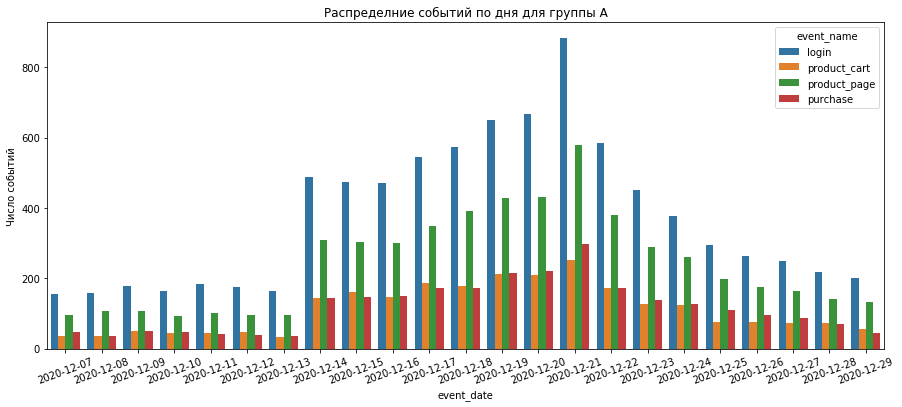

In [27]:
#выделяем дату события из event_date методом dt.date
testA_data['event_date']=testA_data['event_dt'].dt.date
#группируем данные по дням и считаем количество событий каждого вида
distA=testA_data.groupby(['event_date','event_name']).agg({'user_id':'count'}).reset_index()
#задаём графическую область
plt.subplots(figsize=(15,6))
#строим гистограмму событий по дня методом barplot()
sns.barplot(x='event_date',y='user_id',hue='event_name', data=distA)
plt.title('Распределние событий по дня для группы A')
plt.xticks(rotation=20)
plt.ylabel('Число событий')

Из столбчатой диаграммы можно сделать вывод,что для группы А данные распределены между днями неравномерно, поэтому для анализа теста следует исключить дни до 14 декабря 2020 года,так как частота событий намного ниже чем в дни после.Также достаточно подозрительными выглядят дни с 23 декабря, но выкидывать их из анализа мы пока не будем, так как это результат уже теста, и скорее всего в группе B будет аналогичная тенденция.

Text(0, 0.5, 'Число событий')

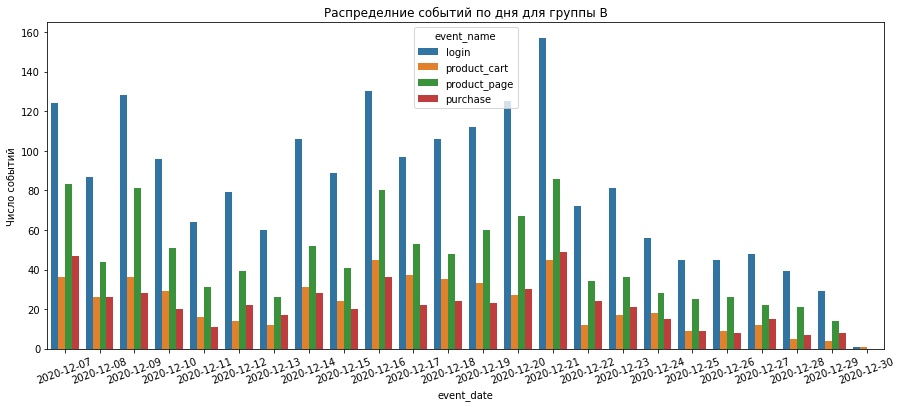

In [28]:
#выделяем дату события из event_date методом dt.date
testB_data['event_date']=testB_data['event_dt'].dt.date
#группируем данные по дням и считаем количество событий каждого вида
distB=testB_data.groupby(['event_date','event_name']).agg({'user_id':'count'}).reset_index()
#задаём графическую область
plt.subplots(figsize=(15,6))
#строим гистограмму событий по дня методом barplot()
sns.barplot(x='event_date',y='user_id',hue='event_name', data=distB)
plt.title('Распределние событий по дня для группы B')
plt.xticks(rotation=20)
plt.ylabel('Число событий')

В группе B данные изначально имели схожую частоту событий и явных отличий нет,не считая 30 декабря. Также можно увидеть схожую тенденцию падения частоты событий после 22 декабря,что и у группы A. Поэтому для правильного проведения статистических тестов исключаем из временного ряда данные раньше 14 декабря 2020 года и заканчиваем анализ 29 декабрём.

In [29]:
#пересобираем данные с учетом выявленных ограничений на даты
start_right_date=pd.to_datetime('2020-12-14')
end_right_date=pd.to_datetime('2020-12-29')
testA_data_=testA_data.query('event_date>=@start_right_date and event_date<=@end_right_date')
testB_data_=testB_data.query('event_date>=@start_right_date and event_date<=@end_right_date')

В графиках распределения числа событий в группах А и B можно увидеть немного разное колебание частоты таких событий как покупка и просмотр карзины. Однако в течении врмени эти событий скачут и внутри каждой группы, поэтому рассчитаем общую частоту событий в каждой группе,чтобы оценить продуктовую воронку.

-Для того чтобы рассчитать частоту событий, нужно посчитать сколько раз совершался каждый вид события в логах, а затем поделить эти данные на суммарное число всех событий(оно ровно длине таблице данных).

In [30]:
#находим суммарное число всех событий в группе А-all_eventsA
all_eventsA=len(testA_data)
#находим суммарное число всех событий в группе B-all_eventsB
all_eventsB=len(testB_data)

In [31]:
#создаем таблицу частот событий группы А, в которой сначала посчитаем число логов с конкретным типом событий
frequencieA=(testA_data.groupby('event_name')['user_id']
             .count()
             .reset_index()
            )
#переименуем столбец 'user_id' в 'count_event' методом .rename() с указанием inplace = True,чтобы не пересохранять датафрейм
frequencieA.rename(columns = {'user_id':'count_event'}, inplace = True)
#и, наконец, добавляем столбец частоты frequencie
frequencieA['frequencie']=frequencieA['count_event']/all_eventsA
frequencieA.sort_values('frequencie', ascending=False)

,event_name,count_event,frequencie
0,login,8566,0.443742
2,product_page,5525,0.286210
3,purchase,2655,0.137536
1,product_cart,2558,0.132511


In [32]:
#посчитаем количество логов каждого вида событий в отсортированных данных, применяя .value_counts()
#также уберем названия событий из индексов при помощи .reset_index(), сохраняем данные в frequencieA_right 
frequencieA_right=testA_data_['event_name'].value_counts().reset_index()
#переименуем столбцы методом .columns
frequencieA_right.columns=['event_name','count_events_right']
frequencieA_right['frequencie_right']=frequencieA_right['count_events_right']/len(testA_data_)
#отсортируем наименования событий по алфавиту .sort_values('event_name')
frequencieA_right=frequencieA_right.sort_values('count_events_right', ascending=False)
frequencieA_right

,event_name,count_events_right,frequencie_right
0,login,7387,0.438658
1,product_page,4828,0.286698
2,purchase,2360,0.140143
3,product_cart,2265,0.134501


In [33]:
#объединяем frequencieA и frequencieA_right по столбцу 'event_name'
frequencieA=frequencieA_right.merge(frequencieA, on='event_name')
#рассчитываем процентное соотношение изменений 
frequencieA['lost_events']=(frequencieA['count_event']-frequencieA['count_events_right'])/frequencieA['count_event']*100
#смотрим итогувую таблицу
frequencieA

,event_name,count_events_right,frequencie_right,count_event,frequencie,lost_events
0,login,7387,0.438658,8566,0.443742,13.763717
1,product_page,4828,0.286698,5525,0.286210,12.615385
2,purchase,2360,0.140143,2655,0.137536,11.111111
3,product_cart,2265,0.134501,2558,0.132511,11.454261


Потеря данных в любом виде событий составила от 11 до 14 процентов,однако частота рспределения событий не изменилась. Следовательно такие ограничение на диапозон событий не составляют больших помех для группы А.


Прлведём аналогичный ананлиз для группы B.

In [34]:
#создаем таблицу частот событий группы B, в которой сначала посчитаем число логов с конкретным типом событий
frequencieB=(testB_data.groupby('event_name')['user_id']
             .count()
             .reset_index()
            )
#переименуем столбец 'user_id' в 'count_event' методом .rename() с указанием inplace = True,чтобы не пересохранять датафрейм
frequencieB.rename(columns = {'user_id':'count_event'}, inplace = True)
#и, наконец, добавляем столбец частоты frequencie
frequencieB['frequencie']=frequencieB['count_event']/all_eventsB
frequencieB.sort_values('frequencie', ascending=False)

,event_name,count_event,frequencie
0,login,1976,0.485862
2,product_page,1048,0.257684
1,product_cart,533,0.131055
3,purchase,510,0.125400


In [35]:
#посчитаем количество логов каждого вида событий в отсортированных данных, применяя .value_counts()
#также уберем названия событий из индексов при помощи .reset_index(), сохраняем данные в frequencieB_right 
frequencieB_right=testB_data_['event_name'].value_counts().reset_index()
#переименуем столбцы методом .columns
frequencieB_right.columns=['event_name','count_events_right']
frequencieB_right['frequencie_right']=frequencieB_right['count_events_right']/len(testB_data_)
#отсортируем наименования событий по алфавиту .sort_values('event_name')
frequencieB_right=frequencieB_right.sort_values('count_events_right', ascending=False)
frequencieB_right

,event_name,count_events_right,frequencie_right
0,login,1337,0.489385
1,product_page,693,0.253660
2,product_cart,363,0.132870
3,purchase,339,0.124085


In [36]:
#объединяем frequencieB и frequencieB_right по столбцу 'event_name'
frequencieB=frequencieB_right.merge(frequencieB, on='event_name')
#рассчитываем процентное соотношение изменений 
frequencieB['lost_events']=(frequencieB['count_event']-frequencieB['count_events_right'])/frequencieB['count_event']*100
#смотрим итогувую таблицу
frequencieB

,event_name,count_events_right,frequencie_right,count_event,frequencie,lost_events
0,login,1337,0.489385,1976,0.485862,32.338057
1,product_page,693,0.253660,1048,0.257684,33.874046
2,product_cart,363,0.132870,533,0.131055,31.894934
3,purchase,339,0.124085,510,0.125400,33.529412


Потеря данных в любом виде событий составила от 32 до 34 процентов, что составляет треть данных, и не смотря на то что частота распределения событий не изменилась, такая потеря данных уже критическая. Однако мы не можем оставлять потерянные данные, так как периоды анализа событий тестовой и контрольной группы должны совпадать, поэтому придется пожертвовать весомым объемом группы B и работать в дальнейшем с отфильтрованными данными, которые хранятся в датасетах testA_data_ и testB_data_.

Также можно отметить,что в обоих группах самыми частыми событиями были ВХОД в личный кабинет и просмотр продуктовых карточек, а вот покупка и просмотр карзины намного реже совершаются.

### Определение числа событий, приходящихся на одного пользователя <a id="events_users"></a>

Ещё проверим сколько событий приходится на одного пользователя в каждой группе. Для этого посчитаем сколько событий совершил каждый пользователь, а затем построим гистограмму распределения числа событий по пользователям.

In [37]:
#группируем данные методом groupby по айди пользователей и считаем число событий приходящихся на них
event_usersA=testA_data_.groupby('user_id')['event_name'].count().reset_index()
#переименновываем столбцы для восприятия понимания содержания столбцов
event_usersA.columns=['user_id','count_event']
#группируем данные event_usersе по количеству событий и считаем сколько пользователей соверило такое число событий
group_countA=event_usersA.groupby('count_event')['user_id'].count().reset_index().sort_values('user_id', ascending=False)
#переименновываем столбцы для восприятия понимания содержания столбцов
group_countA.columns=['count_event','count_users']
group_countA

,count_event,count_users
5,6,541
3,4,413
1,2,292
6,8,247
7,9,243
2,3,241
10,12,227
8,10,84
0,1,77
12,15,72


Аналогичные расчёты делаем в группе B

In [38]:
#группируем данные методом groupby по айди пользователей и считаем число событий приходящихся на них
event_usersB=testB_data_.groupby('user_id')['event_name'].count().reset_index()
#переименновываем столбцы для восприятия понимания содержания столбцов
event_usersB.columns=['user_id','count_event']
#группируем данные event_usersе по количеству событий и считаем сколько пользователей соверило такое число событий
group_countB=event_usersB.groupby('count_event')['user_id'].count().reset_index().sort_values('user_id', ascending=False)
#переименновываем столбцы для восприятия понимания содержания столбцов
group_countB.columns=['count_event','count_users']
group_countB

,count_event,count_users
3,4,131
1,2,125
2,3,104
5,6,102
0,1,37
8,9,36
7,8,32
10,12,23
4,5,7
9,10,7


Text(0.5, 1.0, 'Распределние числа пользователей по количеству \n ,совершенных событий, в группе B')

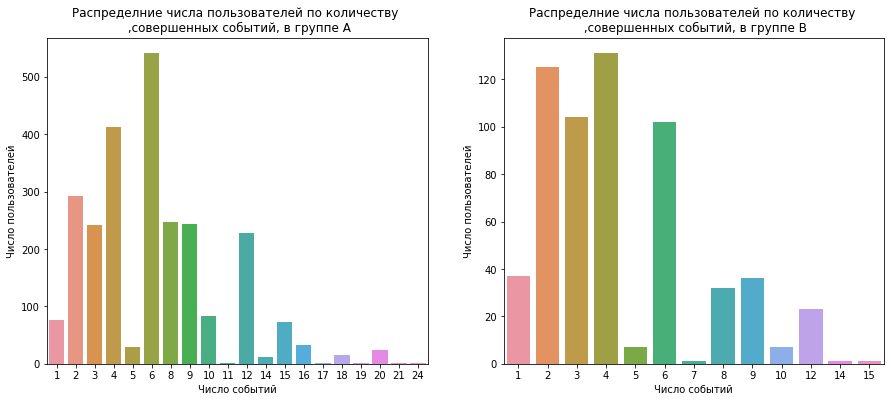

In [39]:
#визуализируем число пользователей по числу событий при помощи графика seaborn.countplot() 
fig, axes = plt.subplots(1, 2, figsize=(15, 6));
#plt.subplot(1,2,1)
for i,df in enumerate([event_usersA,event_usersB]):
    sns.countplot(x='count_event',data=df, ax=axes[i])
    axes[i].set_ylabel('Число пользователей')
    axes[i].set_xlabel('Число событий')
axes[0].set_title('Распределние числа пользователей по количеству \n ,совершенных событий, в группе А')
axes[1].set_title('Распределние числа пользователей по количеству \n ,совершенных событий, в группе B')

Text(0.5, 1.0, 'Распределние числа пользователей \n по количеству видов событий  в группе B')

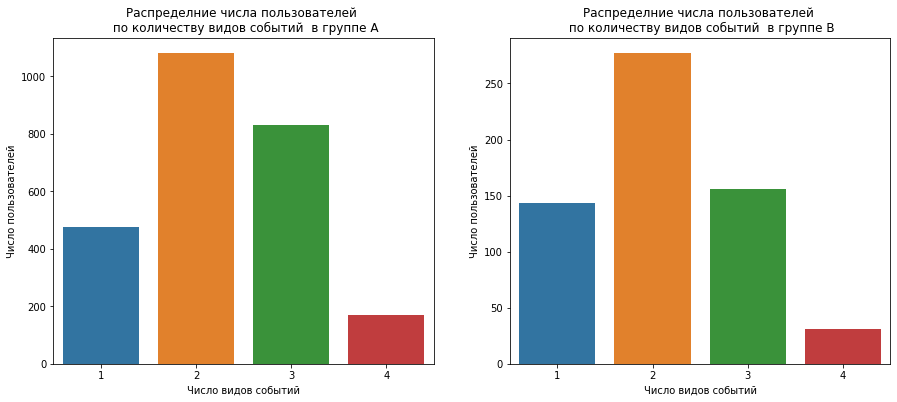

In [40]:
#также проверим распределение числа пользователей по количеству видов событий
fig, axes = plt.subplots(1, 2, figsize=(15, 6));
for i,df in enumerate([testA_data_,testB_data_]):
    sns.countplot(df.groupby('user_id')['event_name'].nunique(), ax=axes[i])
    axes[i].set_ylabel('Число пользователей')
    axes[i].set_xlabel('Число видов событий')
axes[0].set_title('Распределние числа пользователей \n по количеству видов событий  в группе А')
axes[1].set_title('Распределние числа пользователей \n по количеству видов событий  в группе B')

In [41]:
#посчитаем количество логов, приходящихся на каждого пользователя, применяя .value_counts()
#а затем методом median() найдём медианное число событий, которые приходятся на одного пользователя
#искать среднее не имеет смысла, так как есть пользователи с числом событий больше 10,а это уже можно считать выбросами
print('Медианное число событий, приходящихся на одного пользователя в группе А: '
      ,testA_data_['user_id'].value_counts().median())
print('Медианное число событий, приходящихся на одного пользователя в группе B: '
      ,testB_data_['user_id'].value_counts().median())

Медианное число событий, приходящихся на одного пользователя в группе А:  6.0
Медианное число событий, приходящихся на одного пользователя в группе B:  4.0


Число событий на пользователя между группами распределенно почти одинаково. Большинство пользователей совершают от 4 до 6 событий, и лишь малая часть людей соверают больше 12 событий, но ввиду неодинакового распределения пользователей между группами в группе А присуствуют users , которые совершают большее число событий, чем  группе в группе B. 
Также можно сказать, что большинство пользователей совершают по 2-3 вида событий, некоторые люди затрагивают лишь один вид и совсем малая часть всех users совершают 4 события продуктовой воронки.

### Вывод

Во время анализа распредления числа событий тестовой и контрольной группы была обнаружена ещё одна проблема-неравномерное число событий между днями набора новых пользователей и непосредствено дней проведения теста. Так пришлось из-за неполноты данных ограничиться справой стороны датой 29 декабря (после этой даты данные были не предоставлены), а слевой стороны ограничиться 14 декабрём из-за поведения контрольной группы  A. Пересечений пользователей между контрлем и тестом не обнаружено, что хорошо, но было выявлено не большое различие в частоте совершения действий: в контрольной группе  в среднем совершается 6 действий одним пользователем, в то время как в тестовой-4 дествия. Такая ситуация может быть связана с тем,что выборки выбраны не в равных доях, и если бы в группе B пользователей было на 1000 больше, ситуация могла быть иначе, либо эо связано с работой новой рекомендательной системы, где ляюдям приходится меньше совершать действий.

## 4. Работа с продуктовой воронкой <a id="work_with_funnel"></a>

### Работа с пользователями, которые совершают  события <a id="work_with_users"></a>

Ранее уже была получена частота событий в тестовой и котнрольной группе. Теперь определим количество пользователей, которые совершали каждое из видов событий, а также посчитаем долю пользователей, которые хоть раз совершали событие.

In [42]:
#сгруппируем данные по событиям и для каждого из них посчитаем число уникальных пользователей
event_usersA=(testA_data_.groupby('event_name', as_index=False)
             .agg({'user_id':'nunique'})
             .sort_values('user_id')
             .rename(columns={'user_id':'count_users'})
            )
#сохраняем бщее число пользователей в переменную total_users
total_usersA=testA_data_['user_id'].nunique()
#поделим стлобец 'count_users' на 'total_users' для получения доли пользователей, которые хоть раз совершали событие
event_usersA['part']=(event_usersA['count_users']/total_usersA).round(3)
#сортируем события по доли sort_values() 
event_usersA=event_usersA.sort_values('part',ascending=False) 
event_usersA

,event_name,count_users,part
0,login,2559,1.000
2,product_page,1665,0.651
3,purchase,812,0.317
1,product_cart,777,0.304


In [43]:
#сгруппируем данные по событиям и для каждого из них посчитаем число уникальных пользователей
event_usersB=(testB_data_.groupby('event_name', as_index=False)
             .agg({'user_id':'nunique'})
             .sort_values('user_id')
             .rename(columns={'user_id':'count_users'})
            )
#сохраняем бщее число пользователей в переменную total_users
total_usersB=testB_data_['user_id'].nunique()
#поделим стлобец 'count_users' на 'total_users' для получения доли пользователей, которые хоть раз совершали событие
event_usersB['part']=(event_usersB['count_users']/total_usersB).round(3)
#сортируем события по доли sort_values() 
event_usersB=event_usersB.sort_values('part',ascending=False) 
event_usersB

,event_name,count_users,part
0,login,607,1.000
2,product_page,342,0.563
3,purchase,171,0.282
1,product_cart,169,0.278


Для обоих групп совпадает доля пользователей, которые хоть раз совершали каждый вид события, но распределение событий по доли пользователей не совпадает с частотой событий в логах. Не смотря на то число пользователей, которые совершают покупку выше числа пользователей, которые просматривают продуктовую карзину, частота посещения корзины выше, чем частота совершения покупки, а это значит, что возможно существует какой-то баг или неудобство работы с интерфейсом на этапе корзина-покупка и люди просто не могут приступить к покупке и им приходится несколько раз переходить в корзину, либо после каждого добавления товара пользователи переходят в корзину, поэтому разработчикам следует перепроверить работу системы.

Создание и анализ воронки будем осуществлять на всей аудитории теста, поэтому объединим тестовую и контрольную группы.

In [44]:
#allTestdata будет хранить данные тестовой и контрольной группы, для этого при помощи метоад concat() соединим два датафрейма
allTestdata=pd.concat([testA_data_,testB_data_]).reset_index(drop=True)
#event_users-таблица, которая будет хранить информацию о распределнии всех пользователей обоих групп по событиям
event_users=(allTestdata.groupby('event_name', as_index=False)
             .agg({'user_id':'nunique'})
             .sort_values('user_id')
             .rename(columns={'user_id':'count_users'})
            )
#сохраняем бщее число пользователей в переменную total_users
total_users=allTestdata['user_id'].nunique()
#поделим стлобец 'count_users' на 'total_users' для получения доли пользователей, которые хоть раз совершали событие
event_users['part']=(event_users['count_users']/total_users).round(3)
#сортируем события по доли sort_values() 
event_users=event_users.sort_values('part',ascending=False) 
event_users

,event_name,count_users,part
0,login,3166,1.000
2,product_page,2007,0.634
3,purchase,983,0.310
1,product_cart,946,0.299


### Порядк событий <a id="order_of_events"></a>

Не смотря на долевое отношение пользователей, для воронки была выбрана следующуя цепочки действий схожая с частотой распределения событий: вход в личный кабинет-просмотр карточки товаров-продуктовая корзина-оплата. 


Однако мы не знаем, все ли из пользователей, дошедших до покупки, придерживались данной последовательности действий. Для этого отследим последовательность действий по первому времени совершения события каждого пользователя.

In [45]:
#однако нужно не забывать, что существует дата регистрации,которая должна идти впереди всех событий
first_date_users=allTestdata[['user_id','first_date']].groupby('user_id')['first_date'].min().reset_index()

In [46]:
#создадим сводную таблицу users , где индекс- айди пользователя, столбцы - события, а значение- первое время совершения события
users =(allTestdata
        .pivot_table(
            index='user_id', 
            columns='event_name', 
            values='event_dt',
            aggfunc='min')
        .reset_index()
       )
#присоединяем столбец с датой регистрации при помощи объедении таблиц методом merge() по колонке 'user_id'
users=users.merge(first_date_users, on ='user_id')
users.head()

,user_id,login,product_cart,product_page,purchase,first_date
0,0010A1C096941592,2020-12-17 21:07:27,NaT,2020-12-17 21:07:27,2020-12-17 21:07:27,2020-12-17
1,00341D8401F0F665,2020-12-21 11:14:50,NaT,NaT,NaT,2020-12-21
2,003DF44D7589BBD4,2020-12-17 06:17:49,2020-12-17 06:17:49,2020-12-17 06:17:49,NaT,2020-12-17
3,00505E15A9D81546,2020-12-14 17:28:32,NaT,NaT,NaT,2020-12-14
4,005E096DBD379BCF,2020-12-21 07:20:39,NaT,NaT,2020-12-21 07:20:39,2020-12-21


Пропущенные значения Nan значат лишь то,что пользователь не приступал к данному событию, что доказывает наше предположение,что далеко не все пользоатели придержиаются данной цепочки действий.



Нам важна последовательность действий, поэтому вначале мы посчитаем количество пользователей, которые залогинились на сайте. Для этого находим число строк таблицы users, где в столбце first_date не стоит пустое значение.

In [47]:
# создаём срез данных при помощи отрицания ~ всех строк регистрации с NaN
#затем определяем размер таблицы при помощи shape[0]
n_registration = users[~users['first_date'].isna()].shape[0]
print('Посетители, которые зарегестрировались :', n_registration)

Посетители, которые зарегестрировались : 3166


Затем определяется первый шаг цепочки событий-количество людей, которые вошли в личный кабинет, но с уловием,что их дата действия должна быть не старше даты регистрации на сайте.

In [48]:
n_login = users[~users['first_date'].isna() & (users['login'] >= users['first_date'])].shape[0]
print('Посетители, которые вошли в личный кабинет :', n_login)

Посетители, которые вошли в личный кабинет : 3166


Аналогично добавим остальные шаги цепочки и таким образом получим число пользователей для каждого шага будущей воронки.

In [49]:
step_1 = ~users['first_date'].isna()
step_2 = step_1 & (users['login'] >= users['first_date'])
step_3 = step_2 & (users['product_page'] >= users['login'])
step_4 = step_3 & (users['product_cart'] >= users['product_page'])
step_5 = step_4 & (users['purchase'] >= users['product_cart'])

#фильтруем данные users  и методом .shape[0] определяем число пользователей
n_registration=users[step_1].shape[0]
n_login = users[step_2].shape[0]
n_page = users[step_3].shape[0]
n_cart = users[step_4].shape[0]
n_payment = users[step_5].shape[0]

print('Посетители, которые зарегестрировались :', n_registration)
print('Посетители, которые вошли в личный кабинет :', n_login)
print('Посетители, которые увидели карточку с товарами:', n_page)
print('Просмотр корзины с товарами:', n_cart)
print('Оплатили:', n_payment)

Посетители, которые зарегестрировались : 3166
Посетители, которые вошли в личный кабинет : 3166
Посетители, которые увидели карточку с товарами: 2007
Просмотр корзины с товарами: 446
Оплатили: 54


In [50]:
event_users.sort_values('part', ascending=False)

,event_name,count_users,part
0,login,3166,1.000
2,product_page,2007,0.634
3,purchase,983,0.310
1,product_cart,946,0.299


Все пользователи,что зарегестрировались в приложении,входят в личный кабинет. Причем число пользователей на первых двух этапах формировании воронки("login" и "product_page") совпадает с количеством пользователей из подсчета числа событий таблицы event_users, а ,начиная с шага "просмотр корзины", идут большие расхождения по количеству участников(почти в 2 раза и больше). Это значит, что далеко не все пользователи придерживаются ожидаемого пути, некоторые люди могут идти после входа в личный кабинет сразу к корзине или покупке. 

Чтобы доказать теорию о ином порядке событий пользователей, создадим ещё несколько других потенциальных воронок.

У первой альтернативной воронки будет сначала идти вход в личный кабинет,затем сразу переход в корзину, потом просмотр карточки с товарами и покупка.

In [51]:
step_1 = ~users['login'].isna()
step_2 = step_1 & (users['product_cart'] >= users['login'])
step_3 = step_2 & (users['product_page'] >= users['product_cart'])
step_4 = step_3 & (users['purchase'] >= users['product_page'])

#фильтруем данные users  и методом .shape[0] определяем число пользователей
n_login = users[step_1].shape[0]
n_cart = users[step_2].shape[0]
n_page = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('Посетители, которые зарегестрировались:', n_login)
print('Просмотр корзины с товарами:', n_cart)
print('Посетители, которые увидели карточку с товарами:', n_page)
print('Оплатили:', n_payment)

Посетители, которые зарегестрировались: 3166
Просмотр корзины с товарами: 946
Посетители, которые увидели карточку с товарами: 433
Оплатили: 54


Как мы видим, теперь у нас полностью совпали количеством пользователей из таблицы event_users на этапах формировании воронки "login" и "'product_cart'", но при этом число пользователей, которые совершают покупки, не увеличилось. 

Вторая альтернативная воронка вообще не будет содержать события просмотра карточек: человек входит в личный кабинет, идет сразу в корзину и покупает.

In [52]:
step_1 = ~users['login'].isna()
step_2 = step_1 & (users['product_cart'] >= users['login'])
step_3 = step_2 & (users['purchase'] >= users['product_cart'])

#фильтруем данные users  и методом .shape[0] определяем число пользователей
n_login = users[step_1].shape[0]
n_cart = users[step_2].shape[0]
n_payment = users[step_3].shape[0]

print('Посетители, которые зарегестрировались:', n_login)
print('Просмотр корзины с товарами:', n_cart)
print('Оплатили:', n_payment)

Посетители, которые зарегестрировались: 3166
Просмотр корзины с товарами: 946
Оплатили: 125


И наконец третья альтернатиная цепочка- человек вошёл в личный кабинет, посмотрел карточки с товарами, купил и вошел в корзину

In [53]:
step_1 = ~users['first_date'].isna()
step_2 = step_1 & (users['login'] >= users['first_date'])
step_3 = step_2 & (users['product_page'] >= users['login'])
step_4 = step_3 & (users['purchase'] >= users['product_page'])
step_5 = step_4 & (users['product_cart'] >= users['purchase'])

#фильтруем данные users  и методом .shape[0] определяем число пользователей
n_registration=users[step_1].shape[0]
n_login = users[step_2].shape[0]
n_page = users[step_3].shape[0]
n_cart = users[step_5].shape[0]
n_payment = users[step_4].shape[0]

print('Посетители, которые зарегестрировались :', n_registration)
print('Посетители, которые вошли в личный кабинет :', n_login)
print('Посетители, которые увидели карточку с товарами:', n_page)
print('Оплатили:', n_payment)
print('Просмотр корзины с товарами:', n_cart)

Посетители, которые зарегестрировались : 3166
Посетители, которые вошли в личный кабинет : 3166
Посетители, которые увидели карточку с товарами: 2007
Оплатили: 297
Просмотр корзины с товарами: 88


Что и требовалось доказать. Количество пользователей, которые совершают покупки, увеличилось при нестандартном совершении последовательности действий, что доказывает теорию предложенную выше-не все люди придерживаются банального хода событий. Такая ситуация возможна, если у пользователя в личном кабинете к примеру привязана карта и в приложении на странице товара стоят кнопки отдельно купить и отдельно добавить в корзину, при такоом раскладе возможен автоматический платёж со страницы товара без перехода в корзину, или же как вариант развития событий- списание средств в виде предоплаты по заказу или доставке. 

### Анализ  воронки событий <a id="analytic_funnel"></a>

Построим воронку событий по нестандартной третьей алетрнативной цепочки действий и без учета последовательности событий.

In [54]:
#построим таблицу для воронки event_funnel
event_funnel=pd.DataFrame(data={'event_name':  ['Login', 'Product_page','Purchase', 'Product_Cart'],
                                'count_users': event_users['count_users'].values})
event_funnel 

,event_name,count_users
0,Login,3166
1,Product_page,2007
2,Purchase,983
3,Product_Cart,946


По построенной воронке, посчитаем долю пользователей, которые проходят на следующий шаг воронки (от числа пользователей на предыдущем).

In [56]:
def conversion(df:pd.DataFrame, name_column:str):
    conversion=[]
    for i in range(len(df)):
        if i==0:
            yield 100
        else:
            yield round(df.loc[i,name_column]/df.loc[i-1,name_column]*100,0)
event_funnel['conversion']=[x for x in conversion(event_funnel,'count_users')]
event_funnel

,event_name,count_users,conversion
0,Login,3166,100.0
1,Product_page,2007,63.0
2,Purchase,983,49.0
3,Product_Cart,946,96.0


### Вывод

Что касается анализа воронки, то меньше 1/3 пользователей доходят до этапа покупки: 31% пользователей доходят до страницы с оплатой с момента входа в личный кабинет. Причём больше всего пользователей теряется на шаге перехода с просмотра карточек в оплату. Такое являние может быть связано с тем,что пользователей мог не удовлетворить интерфейс страницы, её оформление или удобство с работой, возможно было не очень подробное описание товаров и инструкция прохождения оплаты, или же есть баг кнопки перехода к оплате. Поэтому стоит в будущем проанализировать этот шаг перехода: возможно стоит собрать часть аудитории и получить обратную связь во время проведения интервью, а также провести дополнительное тестирование страницы и кнопок перехода.

## 5.  Оценка результатов A/B тестирования <a id="analytic_test"></a>

Статистический анализ групп будем проводить по конверсии пользователей, которые совершили конкретное событие.

### Результаты А/B тестирования <a id="results"></a>

In [57]:
control_test=(allTestdata
              .pivot_table(index='event_name',
                           columns='group', 
                           values='user_id',
                           aggfunc='nunique')
              .sort_values('A', ascending=False)
             )
control_test

group,A,B
event_name,,
login,2559,607
product_page,1665,342
purchase,812,171
product_cart,777,169


In [58]:
#создаём сводную таблицу, где  индексы-события,столбцы- группы A и B, в которых хранится уникальное число пользователей
#сортируем данные в порядке убывания и сохраняем в control_test
control_test=(allTestdata
              .pivot_table(index='event_name',
                           columns='group', 
                           values='user_id',
                           aggfunc='nunique')
              .sort_values('A', ascending=False)
             )
control_test.columns=['A', 'B']
control_test=control_test.reset_index()
#рассчитываем конверсию в каждой группе
control_test['conversionA']=[x for x in conversion(control_test,'A')]
control_test['conversionB']=[x for x in conversion(control_test,'B')]
#и для статистического теста подтаскиваем число пользователей на прошлое событие
control_test['lastA']=control_test['A'].shift(1)
control_test['lastB']=control_test['B'].shift(1)
control_test.drop(0,axis=0,inplace=True)
control_test=control_test.reset_index(drop=True)
control_test

,event_name,A,B,conversionA,conversionB,lastA,lastB
0,product_page,1665,342,65.0,56.0,2559.0,607.0
1,purchase,812,171,49.0,50.0,1665.0,342.0
2,product_cart,777,169,96.0,99.0,812.0,171.0


На первый взгляд видно,что тест не удался. Ожидаемый эффект от изменений рекомендательной системы заключался в увелечении каждой метрики не менее,чем на 10%, у нас же получилось:
    - конверсия в просмотр карточки упала в тестовой группе по сравнению с контрольной группой,
    - конверсия в покупку в тестовой группе выросла всего на (50-49)/49x100=2% по сравнению с конверсией контрольной группы,
    - конверсия в просмотр продуктовой корзины  выросла всего на (99-96)/96x100=3% по сравнению с конверсией контрольной группы. 

Остаётся проверить значимые ли эти различия.

### Статистический анализ  <a id="statistic_analytic"></a>

Для этого создаём функцию для рассчёта уровня статистической значимости. Так как конверсия - доли(отношения), то статистическую разницу будем искать z-критерием для долей. События воронки - отдельные метрики для одних и тех же двух групп, поэтому понижать критический уровень значимости не надо.

Гипотезы:
    - H0 - конверсии тестовой и контрольной групп не отличаются, 
    - H1- есть различия между конверсиями тестовой и контрольной групп.

In [59]:
def function(A, B,A_total, B_total, alpha):
       
    # пропорция успехов в первой группе:
    p1 = A/A_total

    # пропорция успехов во второй группе:
    p2 = B/B_total
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (A + B)/ (A_total + B_total)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/A_total + 1/B_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value.round(2))

    if (p_value < alpha):
        return ("Отвергаем нулевую гипотезу: между конверсиями есть значимая разница")
    else:
        return ("Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсиями разными")   

In [60]:
#сохраняем ответ в список answer
answer=[]
alpha = .05 # критический уровень статистической значимости
#создаём цикл по прохождению каждого события
for i in range(len(control_test)):
    answer.append(function(control_test.loc[i,'A']
                           ,control_test.loc[i,'B']
                           ,control_test.loc[i,'lastA']
                           ,control_test.loc[i,'lastB']
                           ,alpha))
#сохраняем ответ в колонку 'result_test'    
control_test['result_test']=answer    
control_test    

p-значение:  0.0
p-значение:  0.68
p-значение:  0.05


,event_name,A,B,conversionA,conversionB,lastA,lastB,result_test
0,product_page,1665,342,65.0,56.0,2559.0,607.0,Отвергаем нулевую гипотезу: между конверсиями ...
1,purchase,812,171,49.0,50.0,1665.0,342.0,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,product_cart,777,169,96.0,99.0,812.0,171.0,Отвергаем нулевую гипотезу: между конверсиями ...


Также проанализируем долевые отношения пользователей на каждом этапе событий. 

Гипотезы:
    - H0 - доли тестовой и контрольной групп не отличаются, 
    - H1- есть различия между долями тестовой и контрольной групп.

In [65]:
def function_2(A, B,A_total, B_total, alpha):
       
    # пропорция успехов в первой группе:
    p1 = A/A_total

    # пропорция успехов во второй группе:
    p2 = B/B_total
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (A + B)/ (A_total + B_total)

    # разница пропорций в датасетах
    difference = p1 - p2

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/A_total + 1/B_total))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value.round(2))

    if (p_value < alpha):
        return ("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        return ("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")  

In [66]:
#сохраняем ответ в список answer
answer=[]
alpha = .05 # критический уровень статистической значимости
#создаём цикл по прохождению каждого события
for i in range(len(control_test)):
    answer.append(function_2(control_test.loc[i,'A']
                           ,control_test.loc[i,'B']
                           ,total_usersA
                           ,total_usersB
                           ,alpha))
#сохраняем ответ в колонку 'result_test'    
control_test['result_test']=answer    
control_test    

p-значение:  0.0
p-значение:  0.09
p-значение:  0.22


,event_name,A,B,conversionA,conversionB,lastA,lastB,result_test
0,product_page,1665,342,65.0,56.0,2559.0,607.0,Отвергаем нулевую гипотезу: между долями есть ...
1,purchase,812,171,49.0,50.0,1665.0,342.0,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,product_cart,777,169,96.0,99.0,812.0,171.0,"Не получилось отвергнуть нулевую гипотезу, нет..."


### Вывод

Только в конверсии в покупку уровень значемости не стал меньше критического уровня значимости(ошибки первого рода), поэтому мы отвергаем нулевую гипотезу, то есть рекомендательная система повлияла на 2 из трёх пользовательских метрик, но аннализ конверсий показал, что изменение величины конверсии не для каждой метрики идёт в пользу тестовой группы. 

## Общий вывод <a id="conclusion"></a>

В результате анализа было выяснено,что пользователя совершают не традиционную цепочку событий: после просмотра карточек большая доля пользователя покупают сразу, а не переходят в корзину. Больше всего пользователей теряется на этапе перехода с просмотра карточекг в покупку-51% пользователей потерян. Техникам сотит проверить качество работы кода перехода на страницы, а маркетологам стоит провести дополнительное интервью пользователей по работе с интерфейсом, возможно , проблема связана с неудоством работы или не привлекательным внешним видом.

Анализ A/B-теста показал,что применение новой рекомендательной системы повлияло на конверсию перехода с личного кабинета на карточку продукта и перехода с покупки в корзину, но не показало значимых при конверсии в покупки, при то что новая система повлияла лишь на долю пользователей, которые перешли в продуктовую карточку. Однако нужно отметить,что эти изменения далеко не для каждой метрики идут в пользу тестовой группы, и ожидаемого эффекта ниодна из трёх метрик не достигла. 

Но при проведение дизайна теста были обнаружены большие ошибки, связанные с неравными объемами тестовой и контрольной группы, не выполнения ТЗ по формированию аудитории теста, а также часть пользователей пересекались с парраллельным тестом и сам запуск изменений приходился на Новогодние праздники, когда действую внешние факторы на поведение людей, такие как маркетинговые скидки. Помимо этого были предоставлены не все данные для аннализа, тест длился меньше чем надо. 

Следовательно, считать результаты тесты достоверными нельзя, тест оказался неккоректным, и возможно новая рекомендательная система оказывает реально положительное влияние на конверссии, но для этого нужно провести тестирование по всем правилам.